In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *

In [3]:
import torch

# Shape

In [4]:
dataset = ShapeDataset(seed=12345)

In [6]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=64,
                      num_layers=4)
model.load_state_dict(torch.load('ckpts/shape.pt'))

<All keys matched successfully>

In [7]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.9909999966621399,
 'cm': array([[1568,    7,    1,   20,    0],
        [   8, 1611,    0,    7,    0],
        [   1,    0, 1584,   21,    0],
        [   3,    4,    0, 1616,    0],
        [   0,    0,    0,    0, 1549]]),
 'f1': {'random': 0.98740553855896,
  'lollipop': 0.991995096206665,
  'wheel': 0.9927922487258911,
  'grid': 0.9832674264907837,
  'star': 1.0}}

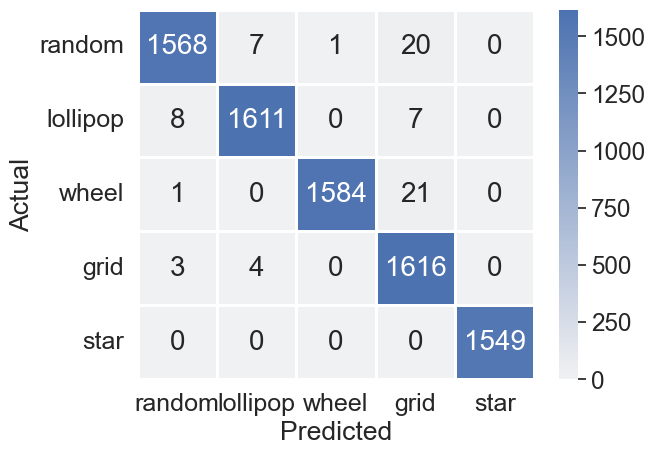

In [9]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [10]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [11]:
trainer = {}
sampler = {}

# Lollipop

In [25]:
cls_idx = 1
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.15,
        learn_node_feat=False
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=5),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=20),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [26]:
cls_idx = 1
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=16 m=34
logits=[-2.5123493671417236, 2.1324427127838135, -16.832082748413086, -15.12959098815918, -73.9304428100586]
probs=[0.009520025923848152, 0.9904800057411194, 5.749857034942352e-09, 3.1552939816492653e-08, 9.165426798987303e-34]


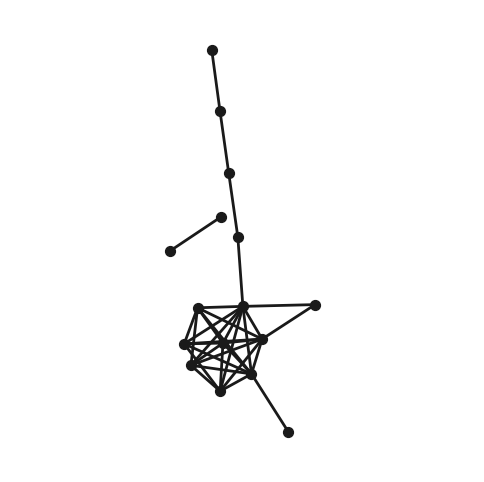

In [27]:
trainer[1].evaluate(threshold=0.5, show=True)

# Wheel

In [87]:
cls_idx = 2
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.15,
        learn_node_feat=False
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=2),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=5),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=2),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=25, order=2, beta=1),
)

In [88]:
cls_idx = 2
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=40,
    w_budget_init=0.2,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=13 m=26
logits=[-7.353414535522461, -22.411876678466797, -3.5287582874298096, -36.285587310791016, -21.52581214904785]
probs=[0.021359741687774658, 6.1629590319967065e-09, 0.9786402583122253, 5.8145123000522426e-15, 1.494865742301954e-08]


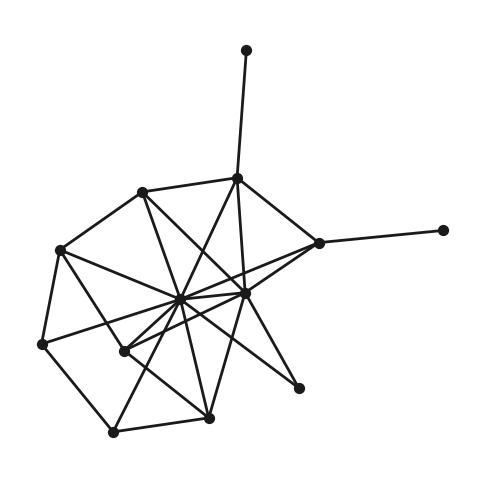

In [89]:
trainer[2].evaluate(threshold=0.5, show=True)

# Grid

In [160]:
cls_idx = 3
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.15,
        learn_node_feat=False
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=2),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=2),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=15),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=20, order=2, beta=1)
)

In [161]:
cls_idx = 3
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=13 m=17
logits=[-5.537380695343018, -15.427905082702637, -26.769681930541992, -0.8409218788146973, -98.59515380859375]
probs=[0.009044979698956013, 4.581499410960532e-07, 5.436709676204243e-12, 0.990954577922821, 3.4892331761687945e-43]


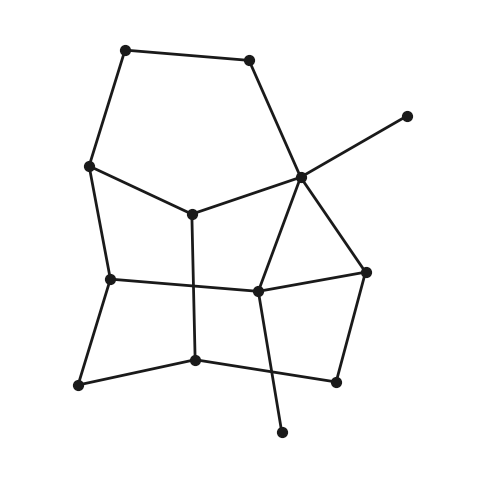

In [162]:
trainer[3].evaluate(threshold=0.5, show=True)

# Star

In [207]:
cls_idx = 4
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.15,
        learn_node_feat=False
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=25, order=2, beta=1),
)

In [208]:
cls_idx = 4
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=30,
    w_budget_init=0.1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=19 m=20
logits=[-65.79411315917969, -235.32423400878906, -49.21257400512695, -276.167236328125, 45.142982482910156]
probs=[0.0, 0.0, 1.0516744974757752e-41, 0.0, 1.0]


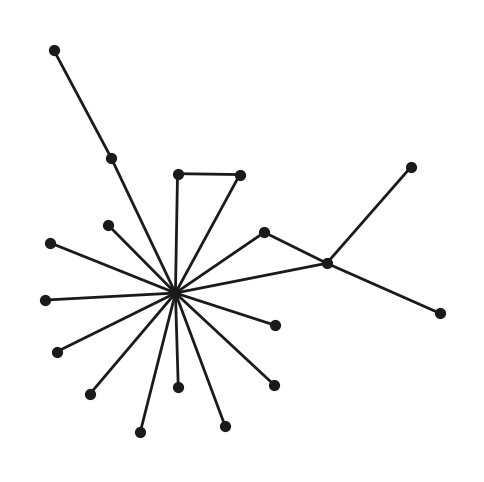

In [209]:
trainer[4].evaluate(threshold=0.5, show=True)